# Fitting Quasar time delay

In [38]:
import matplotlib.pyplot as plt

plt.plot()  # Required to reset the rcParams for some reason
plt.style.use(["default", "./araa-gps.mplstyle"])
plt.close()

In [39]:
import warnings
from functools import partial

import arviz as az
import corner
import jax
import jax.numpy as jnp
import jaxopt
import numpyro
import tinygp
import matplotlib as mpl
from astropy.table import Table
from numpyro import distributions as dist
from numpyro import infer
from tinygp import GaussianProcess, kernels, transforms

from paths import figures
from paths import data as datapath

Start by setting some configuration variables:

In [40]:
warnings.filterwarnings("ignore", category=FutureWarning)
numpyro.set_host_device_count(2)

Next, load the
 that was digitized from the manuscript on ADS: https://ui.adsabs.harvard.edu/abs/1989A%26A...215....1V/abstract

In [41]:
data = Table.read(datapath / "quasar.csv")

Set up the custom GP kernel.
More discussion of this kernel can be found on the tinygp docs here: https://tinygp.readthedocs.io/en/stable/tutorials/quasisep-custom.html#multivariate-quasiseparable-kernels
The basic idea is that each input coordinate is a tuple `(t, band)` where `t` is the time and `band` is the band index (as an integer).
We use the band index to select the kernel amplitude for that data point.


In [42]:
@tinygp.helpers.dataclass
class Multiband(kernels.quasisep.Wrapper):
    amplitudes: jnp.ndarray

    def coord_to_sortable(self, X):
        return X[0]

    def observation_model(self, X):
        return self.amplitudes[X[1]] * self.kernel.observation_model(X[0])

Now we also define functions for the mean and time delay operations.
These also depend on the `band` index, as above.

In [43]:
def time_delay_transform(lag, X):
    t, band = X
    return t - lag * band


def mean_func(means, X):
    t, band = X
    return means[band]

Finally, this is the usual tinyp inference setup (see the [tinygp docs](https://tinygp.readthedocs.io) for more details):

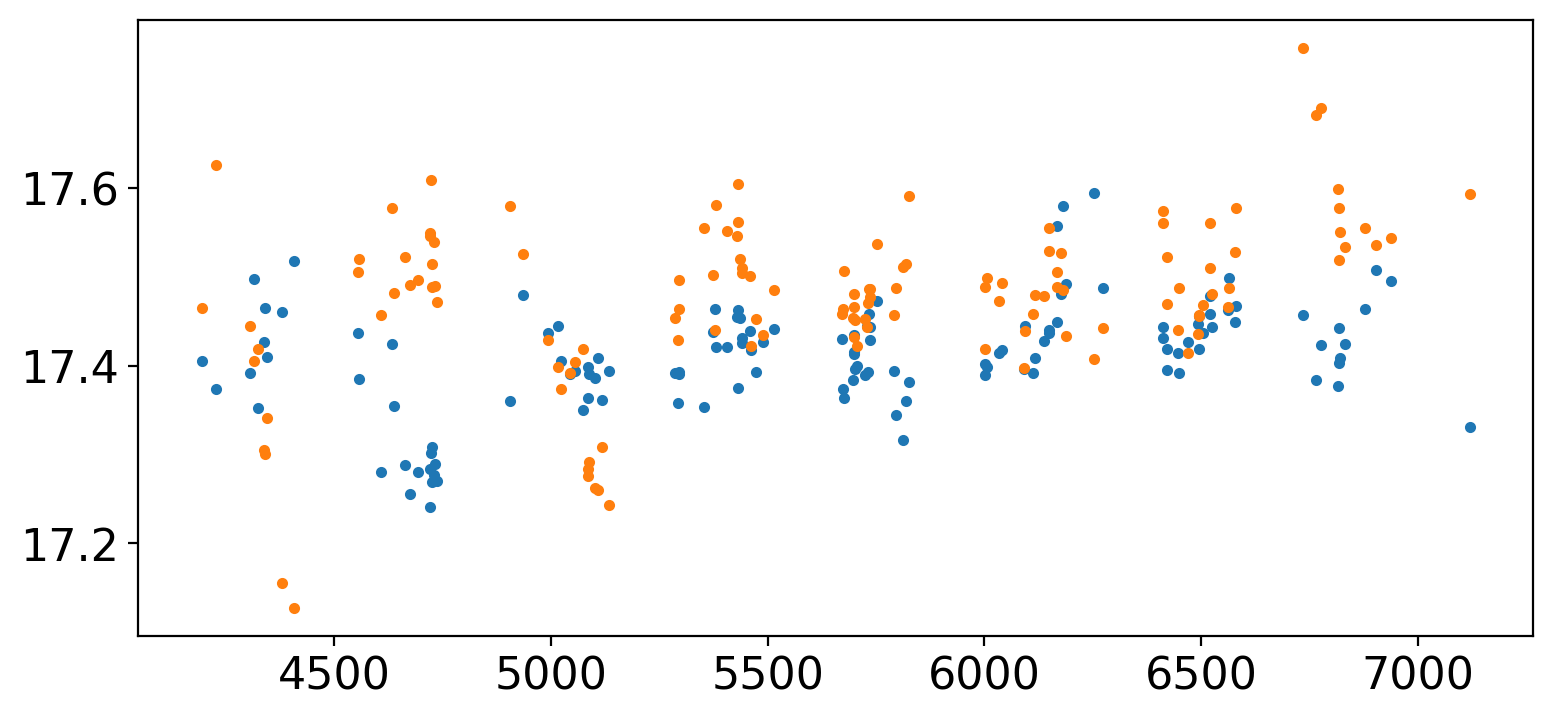

In [44]:
N = len(data)
X = jnp.concatenate((data["jd"].value, data["jd"].value)), jnp.concatenate(
    (jnp.zeros(N, dtype=int), jnp.ones(N, dtype=int))
)
y = jnp.concatenate((data["a_mag"].value, data["b_mag"].value))
diag = jnp.concatenate((data["a_mag_err"].value, data["b_mag_err"].value)) ** 2


def build_gp(params, X, diag):
    band = X[1]
    t = time_delay_transform(params["lag"], X)
    inds = jnp.argsort(t)
    kernel = Multiband(
        amplitudes=params["amps"],
        kernel=kernels.quasisep.Matern32(jnp.exp(params["log_ell"])),
    )
    mean = partial(mean_func, params["means"]) #Format 'mean_func' to require only an X input, so it works as a in-out function. Necessary to feed to Gaussian{Process(). Already defined it in a way that makes "X" input a time / index tuple, and formatted kernel (multiband) to read that sort of input appropriately
    return (
        GaussianProcess(kernel, (t[inds], band[inds]), diag=diag[inds], mean=mean),
        inds,
    )


@jax.jit
def loss(params):
    gp, inds = build_gp(params, X, diag)
    return -gp.log_probability(y[inds])


true_params = {
    "lag": 420.0,
    "log_ell": jnp.log(100.0),
    "amps": jnp.array([0.08, 0.12]),
    "means": jnp.array([17.43, 17.53]),
}
gp, inds = build_gp(true_params, X, diag)
y = jnp.empty_like(y)
y = y.at[inds].set(gp.sample(jax.random.PRNGKey(10)))
plt.plot(X[0][X[1] == 0], y[X[1] == 0], ".", label="a")
plt.plot(X[0][X[1] == 1], y[X[1] == 1], ".", label="b")

To find an initial guess for the time lag, do a set of optimizations starting from a grid of potential lags and select the minimum loss result.
This is similar to the approach used by: https://ui.adsabs.harvard.edu/abs/1992ApJ...385..404P/abstract

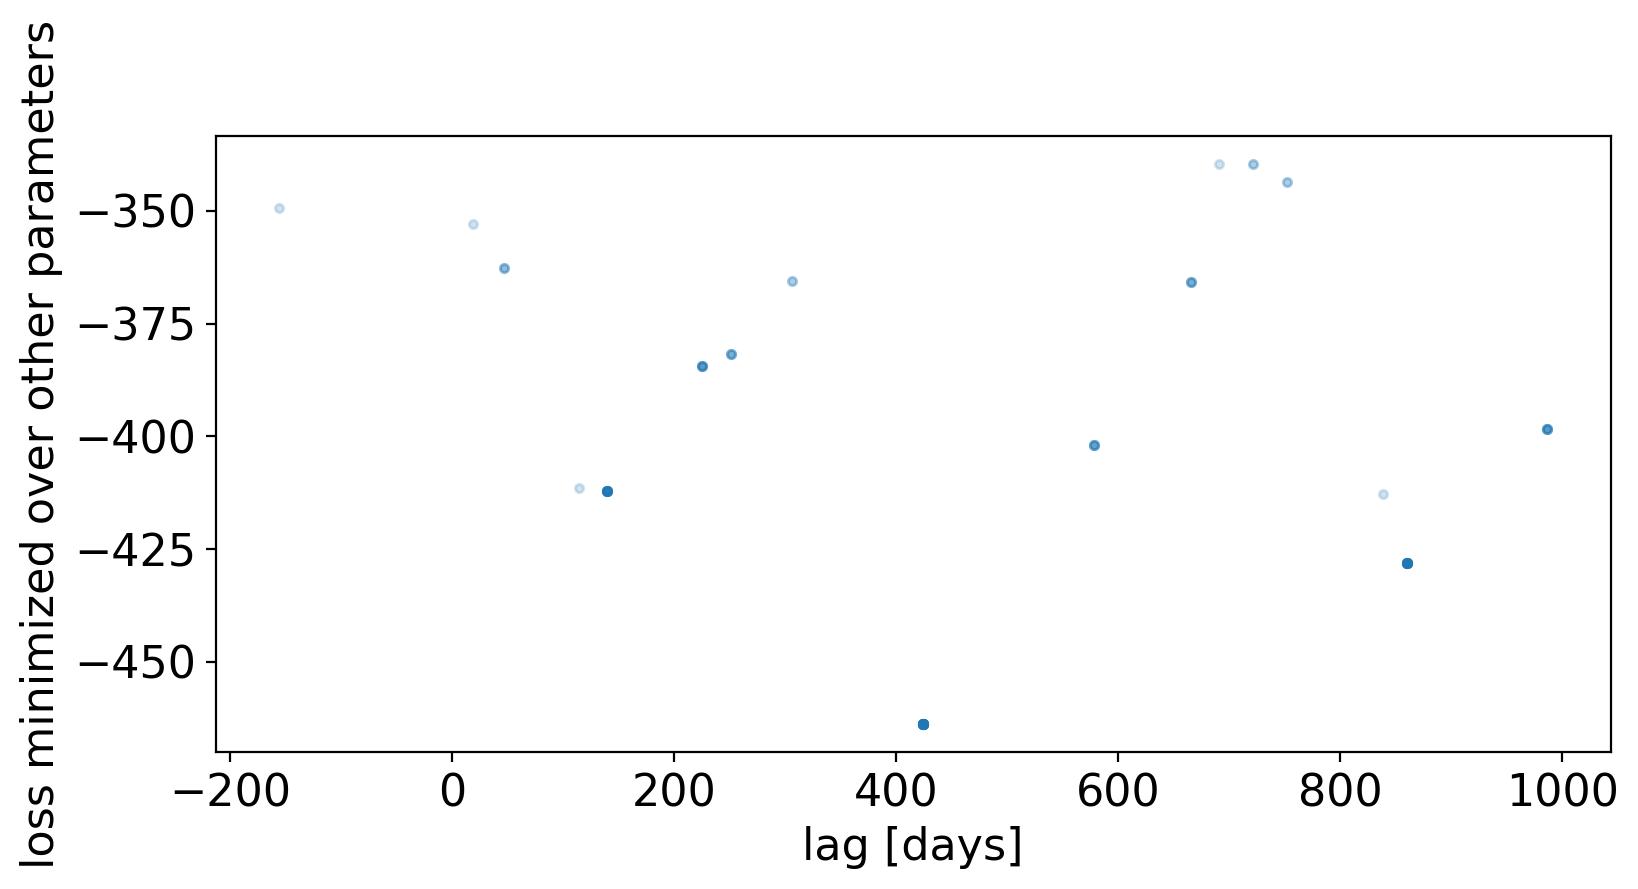

In [45]:
opt = jaxopt.ScipyMinimize(fun=loss)

init = dict(true_params)
minimum = loss(init), init
lags = []
vals = []
for lag in jnp.linspace(0, 1000, 100):
    init["lag"] = lag
    soln = opt.run(init)
    lags.append(soln.params["lag"])
    vals.append(soln.state.fun_val)
    if soln.state.fun_val < minimum[0]:
        minimum = soln.state.fun_val, soln.params
init = minimum[1]

plt.plot(lags, vals, ".", alpha=0.2)
plt.xlabel("lag [days]")
plt.ylabel("loss minimized over other parameters");

Based on the best fit lag, define a grid of times where we'll evaluate the GP's predictive distribution.

In [46]:
t_lagged = X[0] - minimum[1]["lag"] * X[1]
t_grid = jnp.linspace(t_lagged.min() - 200, t_lagged.max() + 200, 1000)

Now, set up the model in NumPyro and run MCMC:

In [ ]:
def model(X, diag, y):
    lag = numpyro.sample("lag", dist.Uniform(0.0, 1000.0))  #Delay
    log_ell = numpyro.sample("log_ell", dist.Uniform(jnp.log(10), jnp.log(1000.0))) #Lengthscale
    amps = numpyro.sample("amps", dist.Uniform(-5.0, 5.0), sample_shape=(2,)) #Band scaling
    mean_a = numpyro.sample("mean_a", dist.Uniform(17.0, 18.0)) #Average of band 0
    delta_mean = numpyro.sample("delta_mean", dist.Uniform(-2.0, 2.0))  #Diff in averages. Odd param but I guess easier to set prior
    means = jnp.stack((mean_a, mean_a + delta_mean))

    #Wrapper to more easily talk to 'build GP', which takes a dictionary in the way we formatted it here
    params = {
        "lag": lag,
        "log_ell": log_ell,
        "amps": amps,
        "means": means,
    }

    gp, inds = build_gp(params, X, diag)
    numpyro.sample("y", gp.numpyro_dist(), obs=y[inds])

    #Condition the GP with each band individually. Note that the X vals are the x vals of the output, not input.
    numpyro.deterministic(
        "pred_a",
        gp.condition(y[inds], (t_grid, jnp.zeros_like(t_grid, dtype=int))).gp.loc,
    )
    numpyro.deterministic(
        "pred_b",
        gp.condition(y[inds], (t_grid, jnp.ones_like(t_grid, dtype=int))).gp.loc,
    )


init_params = dict(minimum[1])
init_params["mean_a"] = init_params["means"][0]
init_params["delta_mean"] = init_params["means"][1] - init_params["means"][0]
sampler = infer.MCMC(
    infer.NUTS(
        model,
        dense_mass=True,
        target_accept_prob=0.9,
        init_strategy=infer.init_to_value(values=init_params),
    ),
    num_warmup=1000,
    num_samples=5000,
    num_chains=2,
    progress_bar=True,
)
%time sampler.run(jax.random.PRNGKey(12), X, diag, y)

Check convergence using ArviZ. The `ess_bulk` gives an estimate of the effective sample size and `r_hat` should be close to 1.

In [48]:
inf_data = az.from_numpyro(sampler)
az.summary(inf_data, var_names=["lag", "delta_mean"])

TypeError: 'NoneType' object is not subscriptable

Plot the inferred parameters and overplot the lag measured by https://ui.adsabs.harvard.edu/abs/1992ApJ...385..404P/abstract

In [ ]:
with mpl.rc_context({"font.size": 14}):
    fig = corner.corner(
        inf_data,
        var_names=["lag", "delta_mean"],
        labels=["time delay [days]", "mean magnitude offset"],
        truths=[true_params["lag"], jnp.diff(true_params["means"])[0]],
    )
    fig.savefig(figures / "quasar_posteriors.pdf", bbox_inches="tight")

Overplot the predictive distributions on the shifted data:

In [ ]:
samples = sampler.get_samples()
lag = jnp.median(samples["lag"])
pred_a = samples["pred_a"]  #Samples indexed by name, including deterministic
pred_b = samples["pred_b"]
inds = jax.random.randint(jax.random.PRNGKey(134), (12,), 0, len(pred_a)) #Get indices of random samples in the chain

offset = 0.3

plt.figure(figsize=(5, 3.5))
#Grabs random samples from pred_a, which ranges over random sets of params. pred_a is conditioned at each sample in the MCMC
plt.plot(t_grid + lag, pred_a[inds, :].T, c="C0", alpha=0.3, lw=0.5)
plt.plot(t_grid + lag, pred_b[inds, :].T + offset, c="C1", alpha=0.3, lw=0.5)

a = X[1] == 0 #boolean switch True such that band index == 0
plt.errorbar(
    X[0][a] + lag, #Moves timestep forward instead of back for reveberation
    y[a],
    yerr=jnp.sqrt(diag[a]), #Just plotting input data /w errors. Remember 'diag' is 'measurement uncertainty in DFM work'
    fmt="oC0",
    label="A",
    markersize=4,
    linewidth=1,
)
b = X[1] == 1
plt.errorbar(
    X[0][b],
    y[b] + offset,
    yerr=jnp.sqrt(diag[b]),
    fmt="oC1",
    label="B",
    markerfacecolor="white",
    markersize=4,
    linewidth=1,
)
plt.ylim(plt.ylim()[::-1])
plt.xlabel(f"time [days; A + {lag:.0f} days]")
plt.ylabel(f"magnitude [B + {offset}]")
plt.xlim(t_grid.min() + lag, t_grid.max() + lag)
plt.legend(loc="lower right", fontsize=10)
plt.savefig(figures / "quasar.pdf", bbox_inches="tight")